# SemEval 2020 Task 12: OffensEval2

## Installing packages

In [11]:
# Install necessary packages

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn

Requirement already up-to-date: symspellpy in /usr/local/lib/python3.6/dist-packages (6.5.2)
Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
     |████████████████████████████████| 174kB 2.8MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


### Mounting drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_DIR = '/content/drive/My Drive/STUDIA/SEM 9/pracownia/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data preprocessing

In [13]:
# All imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [14]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
print(training_dataset.head())
test_tweets_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/testset-levela.tsv'
test_tweets = pd.read_csv(test_tweets_url, delimiter='\t')
print(test_tweets.head())
test_labels_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/labels-levela.csv'
test_labels = pd.read_csv(test_labels_url, delimiter=',', header=None, names=["id", "label"])
print(test_labels.head())
test_dataset = test_tweets.set_index("id").join(test_labels.set_index("id"))
test_dataset.head()

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]
      id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...
      id label
0  15923   OFF
1  27014   NOT
2  30530   NOT
3  13876   NOT
4  60133   OFF


,tweet,label
id,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
13876,#Watching #Boomer getting the news that she is...,NOT
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [0]:
seed = 13

# prepare training examples
training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# prepare test examples and labels
test_examples_A = test_dataset['tweet'][test_dataset['label'].notnull()]
test_labels_A = (test_dataset['label'][test_dataset['label'].notnull()] == 'OFF').astype(int)

# prepare training labels
training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# split training set into training and validation
training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
    training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
    training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
    training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

training_x = list(training_examples_A)
validation_x = list(validation_examples_A)
training_y = list(training_labels_A)
validation_y = list(validation_labels_A)
test_x = list(test_examples_A)
test_y = list(test_labels_A)

In [16]:
# normalization -> papers, complicated solutions

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


# all preprocessing executions
def preprocess_basic(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    text = text.lower()

    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        if flag == True:
            suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            if len(suggestions) > 0:
                edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text


cleaned_x = [preprocess_basic(example) for example in training_x[0:30]]
print(cleaned_x[0:30])
print(training_x[0:30])

[['@user', '@user', '@user', 'know', 'belong', 'violent', 'liberal', 'antifa', 'party', 'w/', 'kkk', 'hood', 'beat', 'total', 'stranger', '&', 'fund', 'party', 'violent', '&', 'corrupt', 'party', 'try', 'pour', 'tear', '&', 'believe', 'heart', 'hard', 'sell', 'include', 'voter'], ['@user', 'lie', 'corrupt', 'traitor', 'nobody', 'want', 'hear', 'anymore', 'lie', 'deep', 'state', 'corruption', 'url'], ['@user', '@user', 'typical', 'liberal', 'principle', 'come', 'money'], ['@user', 'know', 'add', 'million', '@user', 'donation', 'receive', 'access'], ['@user', 'idiot', 'fringe', 'right', 'hate', 'conservative'], ['@user', '@user', '@user', 'think', 'conservative', 'one', 'try', 'rewrite', 'history', 'think', 'face', 'url'], ['@user', '@user', '@user', 'link', 'article', 'show', 'wrong', 'tell', 'libertarian', 'conservative', 'aka', 'right', 'supposedly', 'believe', 'not', 'bigote', 'pattern', 'notice', 'never', 'wrong'], ['@user', 'grit', 'tooth', 'blonde', 'break', 'shield', 'feeling', '

In [0]:
# Remove redundant @user tokens

def remove_redundant_users(example):
  user_count = 0
  new_example = example[:]
  for i, token in reversed(list(enumerate(example))):
    if token == '@user':
      user_count += 1
      if user_count > 3:
        new_example.pop(i)

    else:
      user_count = 0

  return new_example


In [0]:
preprocessed_train = [remove_redundant_users(preprocess_basic(example)) for example in training_x]
preprocessed_valid = [remove_redundant_users(preprocess_basic(example)) for example in validation_x]
preprocessed_test = [remove_redundant_users(preprocess_basic(example)) for example in test_x]

### Class imbalance

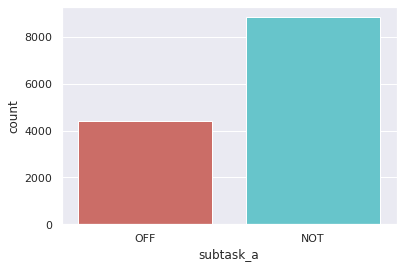

subtask_a
NOT    8840
OFF    4400
Name: id, dtype: int64


In [12]:
#Depict class imbalance for the subtask A
sns.set(font_scale=1.0)
countplt=sns.countplot(x='subtask_a', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('subtask_a').count()['id'])

## Creating new Word2vec embeddings

In [0]:
vocab = preprocessed_train + preprocessed_valid + preprocessed_test   # is that correct?

In [14]:
max_lenght = 0
for line in vocab:
    max_lenght = max(max_lenght, len(line))

max_lenght

48

In [0]:
from gensim.models import Word2Vec
# word2vec = Word2Vec(vocab, size=100, min_count=2)     # would bigger size be better?
# word2vec.save(PATH_TO_DIR + "word2vec.model")

word2vec = Word2Vec.load(PATH_TO_DIR + "word2vec.model")

In [20]:
sim_words = word2vec.wv.most_similar('maga')

for i in sim_words[:10]:
    print(i)

('q', 0.9915871024131775)
('red', 0.9908347129821777)
('wwg1wga', 0.9839978218078613)
('kag', 0.9830963611602783)
('awakening', 0.9806053638458252)
('non', 0.9799588918685913)
('cot', 0.9780389666557312)
('trump', 0.9777174592018127)
('walk', 0.9708099365234375)
('america', 0.9667493104934692)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [42]:
word2vec2.save(PATH_TO_DIR + "word2vec1.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [21]:
w2v_weights = word2vec.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 7364 - Embedding Dim: 100


In [22]:
for k in word2vec.wv.vocab.keys():
    if (word2vec.wv.vocab[k].index == 0):  # is that safe then? don't we have to omit 0 index?
        print(k)

@user


In [23]:
from keras.initializers import Constant
from keras.layers import Embedding

embedding_layer_new = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=max_lenght,
                    embeddings_initializer=Constant(w2v_weights),   # weights=[w2v_weights]     works fine also
                    mask_zero=True, 
                    trainable=False)

Using TensorFlow backend.


## Pretrained embeddings (GloVe twitter)

In [0]:
import os

embeddings_index = {}
with open(os.path.join(PATH_TO_DIR, 'glove.twitter.27B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

# prepare embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, vec in word2vec.wv.vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[vec.index] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer_pretrained = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_lenght,
                            trainable=False,
                            mask_zero=True)

## Preparing suitable data representation

In [0]:
def word2idx(word):
    try:
        return word2vec.wv.vocab[word].index
    except KeyError:
        return 0
        
def idx2word(token):
    return word2vec.wv.index2word[token]

In [0]:
def word2idx_set(X):
    new_X = []

    for line in X:
        new_line = []
        for w in line:
            new_line.append(word2idx(w))
        new_X.append(new_line)
    
    return new_X

In [76]:
from keras.preprocessing.sequence import pad_sequences

X_train1 = np.asarray(word2idx_set(preprocessed_train))
X_train1 = pad_sequences(X_train1, maxlen=max_lenght, padding='pre', value=0)

X_valid1 = np.asarray(word2idx_set(preprocessed_valid))
X_valid1 = pad_sequences(X_valid1, maxlen=max_lenght, padding='pre', value=0)

X_test1 = np.asarray(word2idx_set(preprocessed_test))
X_test1 = pad_sequences(X_test1, maxlen=max_lenght, padding='pre', value=0)

X_train.shape, X_valid.shape, X_test.shape

((11916, 48), (1324, 48), (860, 48))

In [28]:
X_train[0]    # exemplary sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   12,  970,  302,
          3,    6,   48, 1443,  496, 1060,  286,  553, 1311,   16,  272,
         48,  302,   16,  353,   48,   29, 3577,  773,   16,   42,  481,
        153,  425,  442,  354], dtype=int32)

## Helper functins

In [0]:
def get_model_checkpoint(name):
    return ModelCheckpoint(PATH_TO_DIR + name,
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

In [0]:
def plot_history(history):
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## LSTM model

In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint

### Bidirectionl LSTM (+glove) 83%

In [78]:
model = Sequential()

model.add(embedding_layer_pretrained)

model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 897,401
Trainable params: 161,001
Non-trainable params: 736,400
_________________________________________________________________


In [33]:
## using pretrained embeddings (second attempt)
model_name = 'bidir_glove_v3'

history = model.fit(X_train, training_y, epochs=10, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')




Train on 11916 samples, validate on 1324 samples
Epoch 1/10





11916/11916 [==============================] - 62s 5ms/step - loss: 0.5523 - acc: 0.7281 - val_loss: 0.4851 - val_acc: 0.7764

Epoch 00001: val_loss improved from inf to 0.48506, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove_v3.h5
Epoch 2/10
11916/11916 [==============================] - 52s 4ms/step - loss: 0.4959 - acc: 0.7662 - val_loss: 0.4706 - val_acc: 0.7870

Epoch 00002: val_loss improved from 0.48506 to 0.47060, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove_v3.h5
Epoch 3/10
11916/11916 [==============================] - 52s 4ms/step - loss: 0.4744 - acc: 0.7752 - val_loss: 0.4690 - val_acc: 0.7795

Epoch 00003: val_loss improved from 0.47060 to 0.46902, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove_v3.h5
Epoch 4/10
11916/11916 [==============================] - 51s 4ms/step - loss: 0.4595 - acc: 0.7868 - val_l

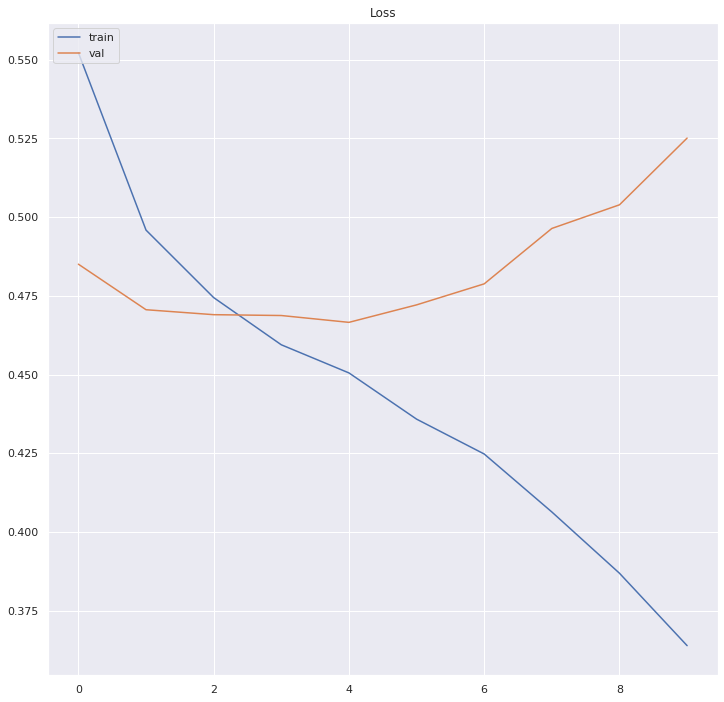

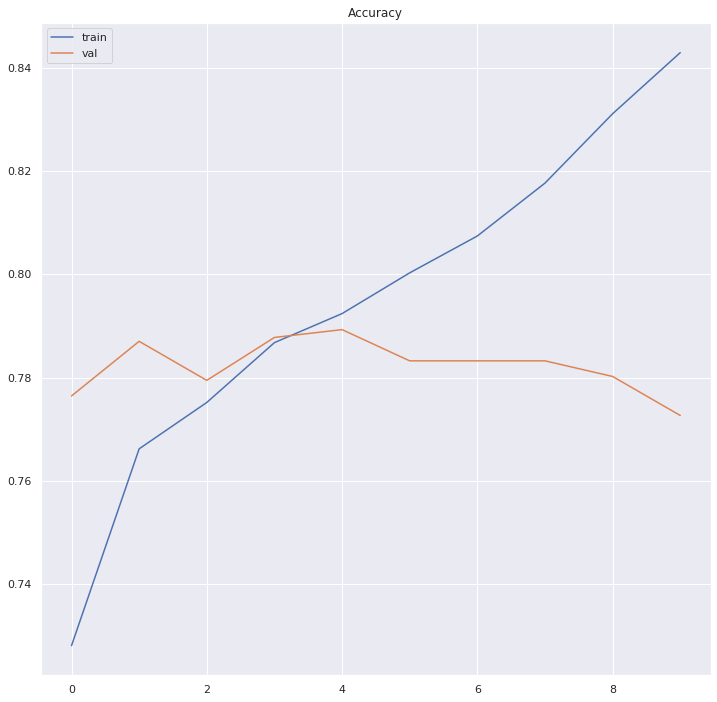

In [34]:
plot_history(history)

In [35]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 2ms/step


[0.4427264776340751, 0.7930232566456462]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_' + model_name + '.h5')

In [45]:
model.evaluate(X_test, test_y, batch_size=64)   # best so far

860/860 [==============================] - 1s 2ms/step


[0.3982633991296901, 0.8197674415832342]

In [0]:
preds_lstm = model.predict(X_test, batch_size=64)
preds_lstm = np.squeeze(preds_lstm)
preds_lstm.shape

In [84]:
## using pretrained embeddings
model_name = 'bidir_glove'

history = model.fit(X_train, training_y, epochs=10, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/10
11916/11916 [==============================] - 28s 2ms/step - loss: 0.5377 - acc: 0.7283 - val_loss: 0.4844 - val_acc: 0.7666

Epoch 00001: val_loss improved from inf to 0.48436, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove.h5
Epoch 2/10
11916/11916 [==============================] - 26s 2ms/step - loss: 0.4889 - acc: 0.7713 - val_loss: 0.4781 - val_acc: 0.7696

Epoch 00002: val_loss improved from 0.48436 to 0.47809, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove.h5
Epoch 3/10
11916/11916 [==============================] - 26s 2ms/step - loss: 0.4753 - acc: 0.7785 - val_loss: 0.4695 - val_acc: 0.7711

Epoch 00003: val_loss improved from 0.47809 to 0.46948, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_glove.h5
Epoch 4/10
11916/11916 [==============================] - 27s 2ms/step - loss: 0.4652 - acc: 0.7818 - val_loss: 0.4643 - val

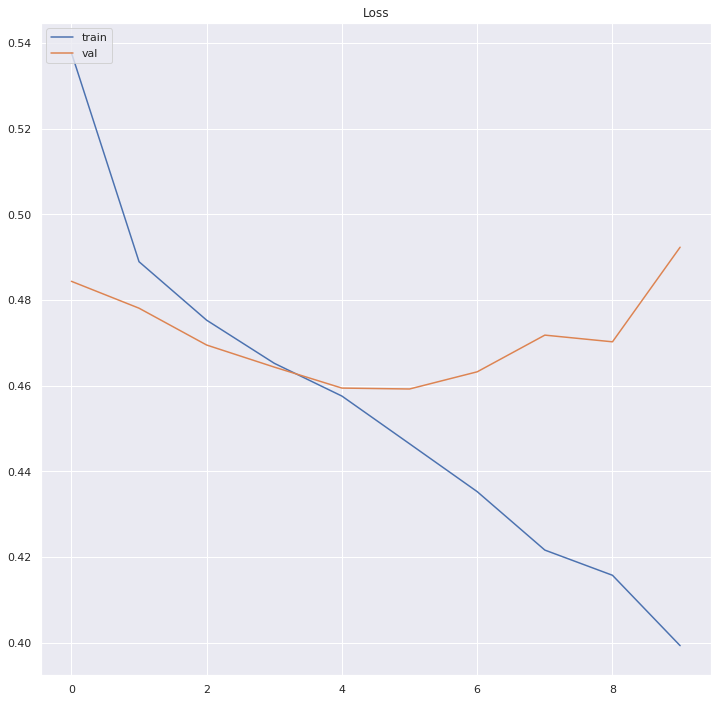

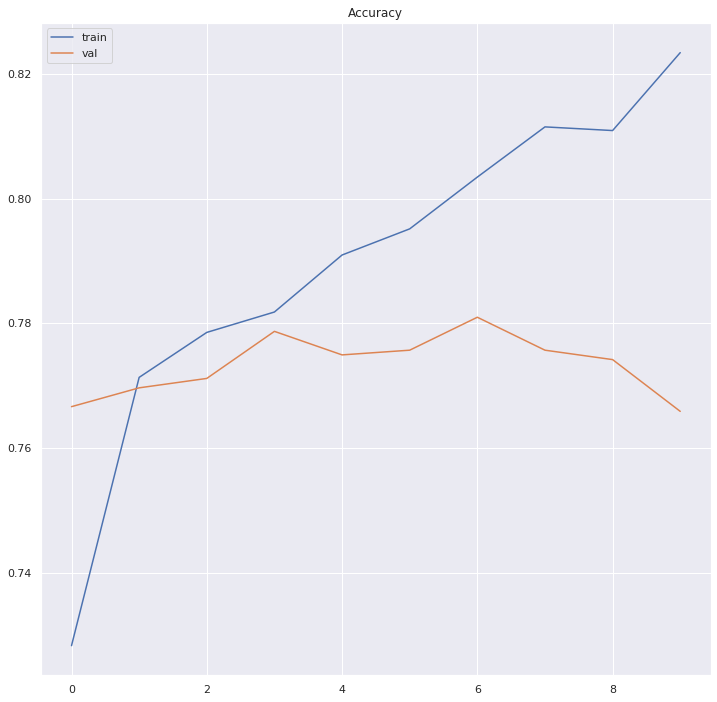

In [85]:
plot_history(history)

In [86]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 859us/step


[0.4352450415145519, 0.7732558139534884]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_' + model_name + '.h5')

In [89]:
model.evaluate(X_test, test_y, batch_size=64)   # best so far

860/860 [==============================] - 1s 845us/step


[0.3871650977190151, 0.8325581392576528]

In [33]:
## using new embeddings
model_name = 'bidir_corrected'

history = model.fit(X_train, training_y, epochs=10, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/10
11916/11916 [==============================] - 50s 4ms/step - loss: 0.6302 - acc: 0.6664 - val_loss: 0.6280 - val_acc: 0.6677

Epoch 00001: val_loss improved from inf to 0.62801, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_corrected.h5
Epoch 2/10
11916/11916 [==============================] - 50s 4ms/step - loss: 0.6297 - acc: 0.6668 - val_loss: 0.6286 - val_acc: 0.6677

Epoch 00002: val_loss did not improve from 0.62801
Epoch 3/10
11916/11916 [==============================] - 51s 4ms/step - loss: 0.6286 - acc: 0.6674 - val_loss: 0.6288 - val_acc: 0.6707

Epoch 00003: val_loss did not improve from 0.62801
Epoch 4/10
11916/11916 [==============================] - 51s 4ms/step - loss: 0.6287 - acc: 0.6670 - val_loss: 0.6285 - val_acc: 0.6677

Epoch 00004: val_loss did not improve from 0.62801
Epoch 5/10
11916/11916 [==============================] - 51s 4ms/step - loss: 0.6287 - acc: 0.6672 - val_l

In [58]:
## no embeddings
model_name = 'bidir_no_w2v'

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')



Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 37s 3ms/step - loss: 0.5741 - acc: 0.7231 - val_loss: 0.5136 - val_acc: 0.7553

Epoch 00001: val_loss improved from inf to 0.51363, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_no_w2v.h5
Epoch 2/5
11916/11916 [==============================] - 35s 3ms/step - loss: 0.4108 - acc: 0.8250 - val_loss: 0.5062 - val_acc: 0.7666

Epoch 00002: val_loss improved from 0.51363 to 0.50617, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir_no_w2v.h5
Epoch 3/5
11916/11916 [==============================] - 35s 3ms/step - loss: 0.3109 - acc: 0.8740 - val_loss: 0.5814 - val_acc: 0.7424

Epoch 00003: val_loss did not improve from 0.50617
Epoch 4/5
11916/11916 [==============================] - 35s 3ms/step - loss: 0.2208 - acc: 0.9167 - val_loss: 0.6592 - val_acc: 0.7228

Epoch 00004: val_loss did not improve from 0.50617
Epoch 5/5
11916/11916 [

In [0]:
## new embeddings trainable...
model_name = 'bidir'

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 38s 3ms/step - loss: 0.6280 - acc: 0.6677 - val_loss: 0.5818 - val_acc: 0.7032

Epoch 00001: val_loss improved from inf to 0.58182, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir.h5
Epoch 2/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.4907 - acc: 0.7734 - val_loss: 0.5058 - val_acc: 0.7711

Epoch 00002: val_loss improved from 0.58182 to 0.50576, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir.h5
Epoch 3/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.3573 - acc: 0.8515 - val_loss: 0.5854 - val_acc: 0.7470

Epoch 00003: val_loss did not improve from 0.50576
Epoch 4/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.2833 - acc: 0.8858 - val_loss: 0.6982 - val_acc: 0.7440

Epoch 00004: val_loss did not improve from 0.50576
Epoch 5/5
11916/11916 [================

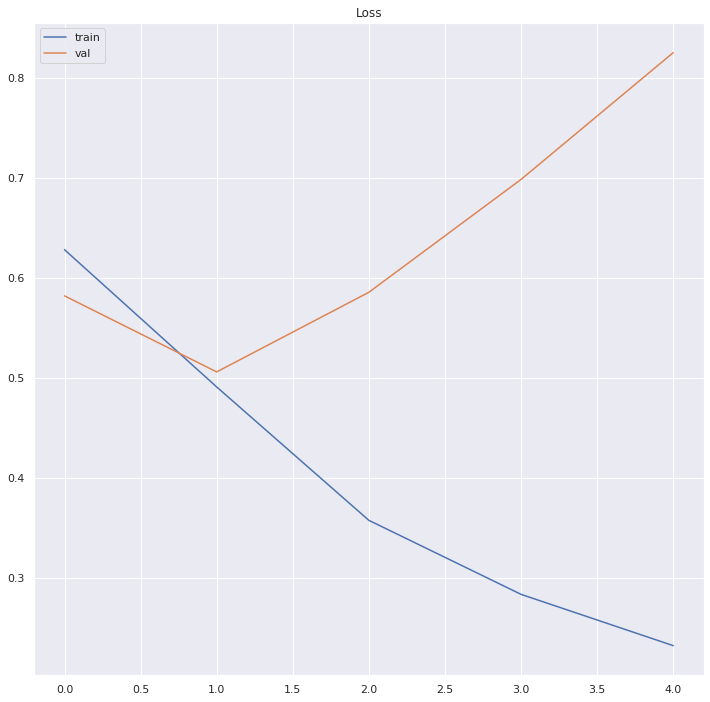

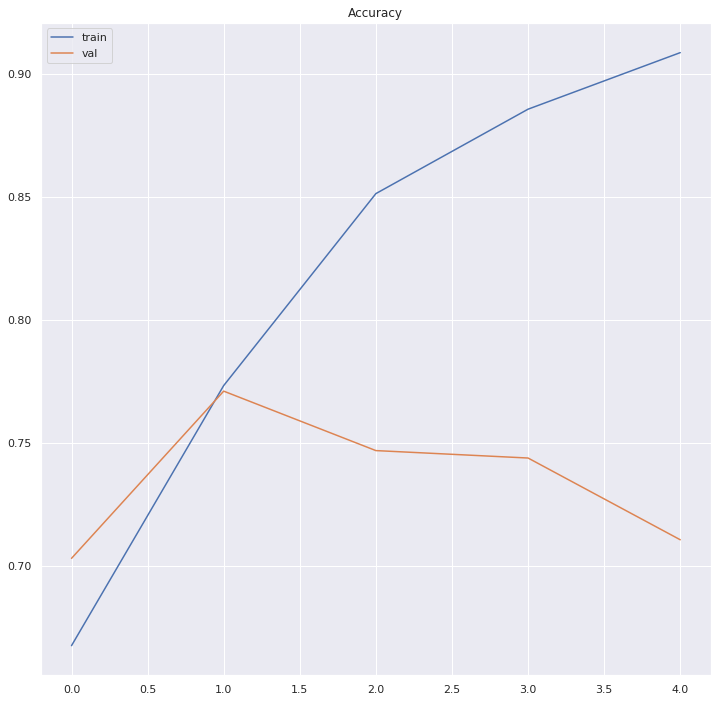

In [0]:
plot_history(history)

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 1ms/step


[0.7751507330772489, 0.7406976746958356]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_bidir.h5')

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 1ms/step


[0.4394642321176307, 0.8104651162790698]

### LSTM with recurrent dropout (+glove) 82%

In [0]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght,
                    mask_zero=True))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 816,901
Trainable params: 816,901
Non-trainable params: 0
_________________________________________________________________




In [0]:
## new embeddings trainable...
history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best.h5')])

model.save_weights(PATH_TO_DIR + 'check2.h5')



Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 24s 2ms/step - loss: 0.6328 - acc: 0.6685 - val_loss: 0.5959 - val_acc: 0.6767

Epoch 00001: val_loss improved from inf to 0.59593, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best.h5
Epoch 2/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.5102 - acc: 0.7572 - val_loss: 0.5136 - val_acc: 0.7492

Epoch 00002: val_loss improved from 0.59593 to 0.51363, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best.h5
Epoch 3/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.3832 - acc: 0.8364 - val_loss: 0.5458 - val_acc: 0.7583

Epoch 00003: val_loss did not improve from 0.51363
Epoch 4/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.3061 - acc: 0.8728 - val_loss: 0.6315 - val_acc: 0.7508

Epoch 00004: val_loss did not improve from 0.51363
Epoch 5/5
11916/11916 [==========================

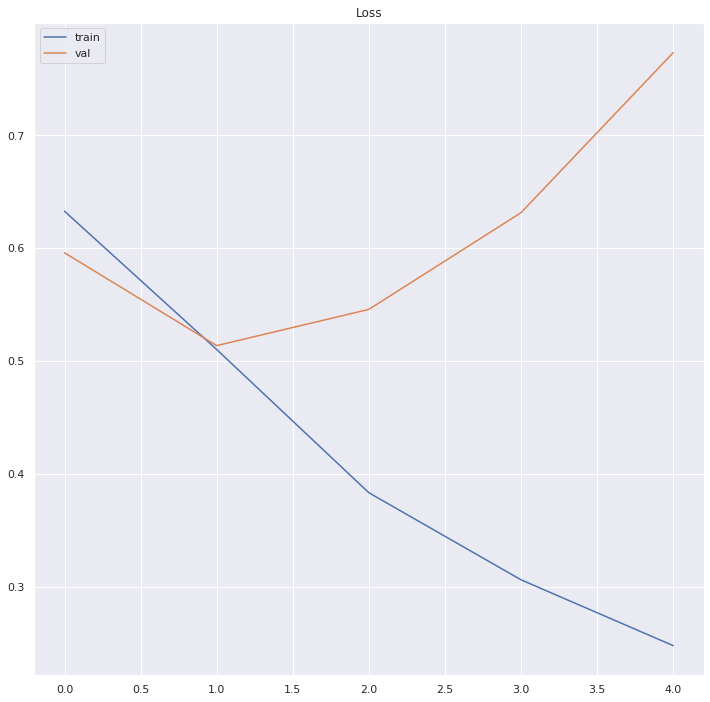

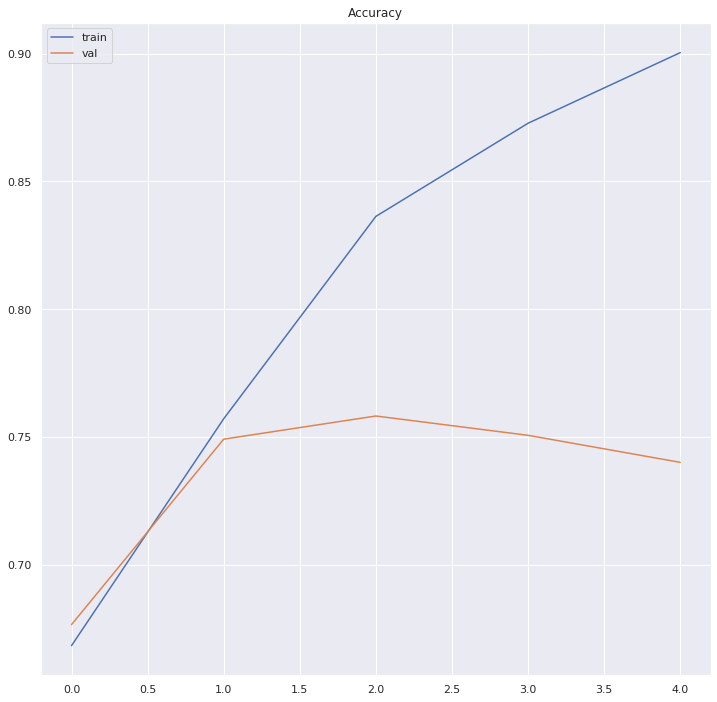

In [0]:
plot_history(history)

In [0]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 1s 710us/step


[0.6473598527353863, 0.7569767450177393]

In [0]:
model.load_weights(PATH_TO_DIR + 'best.h5')

In [0]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 1s 642us/step


[0.4317082051620927, 0.8104651171107625]

In [91]:
## pretrained embeddings
model_name = 'lstm_glove'

history = model.fit(X_train, training_y, epochs=10, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + model_name + '.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/10
11916/11916 [==============================] - 16s 1ms/step - loss: 0.5479 - acc: 0.7281 - val_loss: 0.4961 - val_acc: 0.7659

Epoch 00001: val_loss improved from inf to 0.49614, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_lstm_glove.h5
Epoch 2/10
11916/11916 [==============================] - 14s 1ms/step - loss: 0.4915 - acc: 0.7645 - val_loss: 0.4708 - val_acc: 0.7734

Epoch 00002: val_loss improved from 0.49614 to 0.47076, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_lstm_glove.h5
Epoch 3/10
11916/11916 [==============================] - 14s 1ms/step - loss: 0.4747 - acc: 0.7794 - val_loss: 0.4677 - val_acc: 0.7764

Epoch 00003: val_loss improved from 0.47076 to 0.46765, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_lstm_glove.h5
Epoch 4/10
11916/11916 [==============================] - 14s 1ms/step - loss: 0.4660 - acc: 0.7842 - val_loss: 0.4621 - val_ac

In [92]:
model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), verbose=1, callbacks=[mc])

Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 14s 1ms/step - loss: 0.4172 - acc: 0.8126 - val_loss: 0.4639 - val_acc: 0.7749

Epoch 00001: val_loss did not improve from 0.45457
Epoch 2/5
11916/11916 [==============================] - 15s 1ms/step - loss: 0.4026 - acc: 0.8182 - val_loss: 0.4688 - val_acc: 0.7847

Epoch 00002: val_loss did not improve from 0.45457
Epoch 3/5
11916/11916 [==============================] - 14s 1ms/step - loss: 0.3950 - acc: 0.8225 - val_loss: 0.4704 - val_acc: 0.7795

Epoch 00003: val_loss did not improve from 0.45457
Epoch 4/5
11916/11916 [==============================] - 14s 1ms/step - loss: 0.3822 - acc: 0.8282 - val_loss: 0.4745 - val_acc: 0.7757

Epoch 00004: val_loss did not improve from 0.45457
Epoch 5/5
11916/11916 [==============================] - 14s 1ms/step - loss: 0.3733 - acc: 0.8344 - val_loss: 0.4804 - val_acc: 0.7772

Epoch 00005: val_loss did not improve from 0.45457


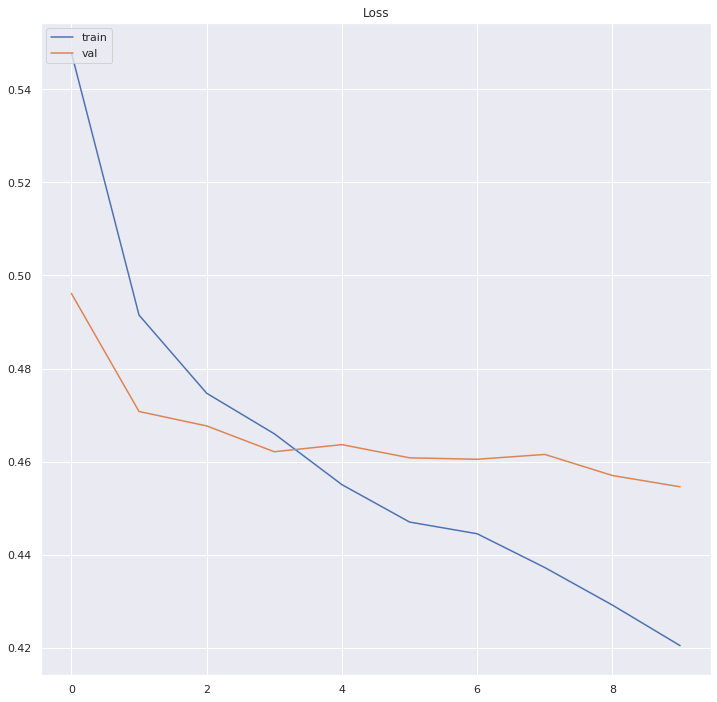

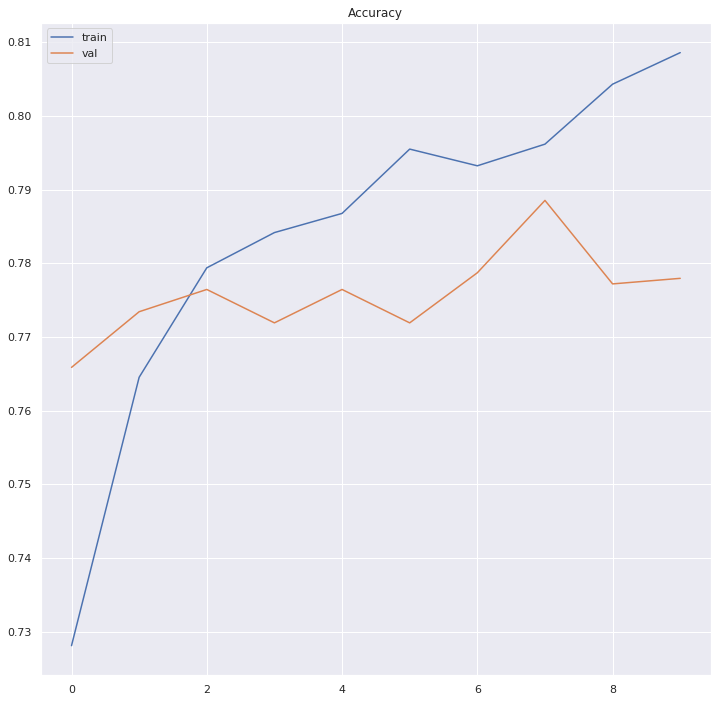

In [93]:
plot_history(history)

In [94]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 0s 516us/step


[0.43193472970363705, 0.7953488377637641]

In [0]:
model.save_weights(PATH_TO_DIR + 'lstm_glove_continue.h5')

In [0]:
model.load_weights(PATH_TO_DIR + 'best_' + model_name + '.h5')

In [97]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 0s 486us/step


[0.3914153613323389, 0.8197674426921578]

### LSTM with L2 regulatization 80%

In [0]:
from keras.regularizers import l2

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght,
                    mask_zero=True))

model.add(LSTM(100))
model.add(Dense(max_lenght, activation='relu', W_regularizer=l2(0.90)))
model.add(Dense(1, activation='sigmoid', W_regularizer=l2(0.1)))
model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(48, activation="relu", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
## new embeddings trainable...
history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_reg.h5')])

model.save_weights(PATH_TO_DIR + 'check_reg.h5')



Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 19s 2ms/step - loss: 19.2941 - acc: 0.6677 - val_loss: 2.7003 - val_acc: 0.6677

Epoch 00001: val_loss improved from inf to 2.70026, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 2/5
11916/11916 [==============================] - 18s 2ms/step - loss: 1.1346 - acc: 0.6677 - val_loss: 0.6650 - val_acc: 0.6677

Epoch 00002: val_loss improved from 2.70026 to 0.66495, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 3/5
11916/11916 [==============================] - 18s 2ms/step - loss: 0.6310 - acc: 0.6677 - val_loss: 0.6254 - val_acc: 0.6677

Epoch 00003: val_loss improved from 0.66495 to 0.62541, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 4/5
11916/11916 [==============================] - 19s 2ms/step - loss: 0.5875 - acc: 0.7120 - val_loss: 0.6150 - val_acc: 0.7545

Epoch 00004

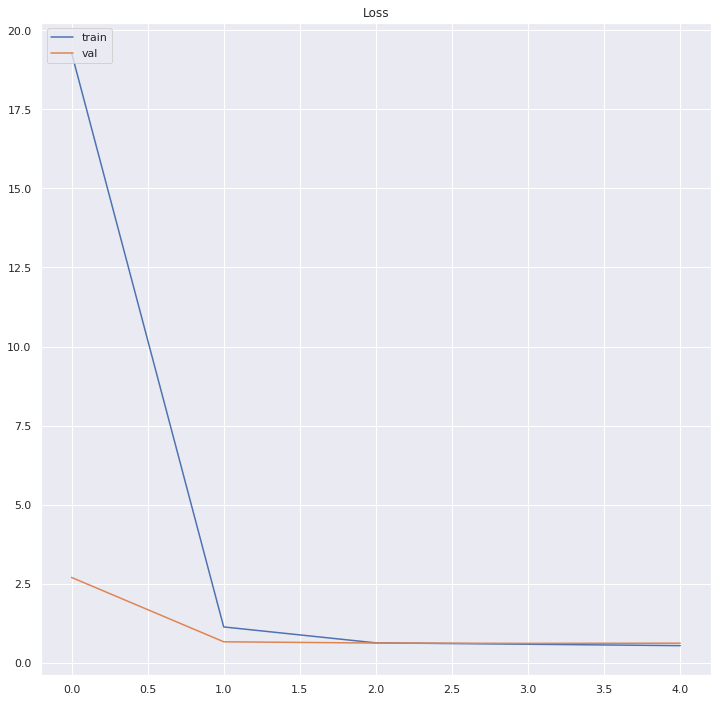

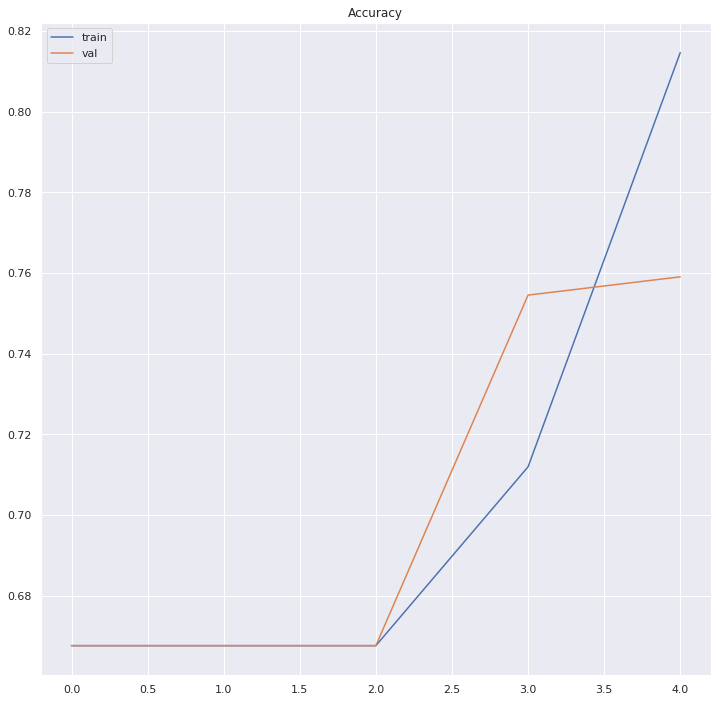

In [0]:
plot_history(history)

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 512us/step


[0.5630058126394138, 0.8023255819498106]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_reg.h5')

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 537us/step


[0.5659678345502809, 0.7930232563684153]

### LSTM model with convolution layer 78%

In [0]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 799,333
Trainable params: 799,333
Non-trainable params: 0
_________________________________________________________________


In [0]:
## new embeddings trainable...
history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), 
                    callbacks=[get_model_checkpoint('best_conv.h5')])

model.save_weights(PATH_TO_DIR + 'check_conv.h5')

Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 10s 798us/step - loss: 0.6285 - acc: 0.6641 - val_loss: 0.6245 - val_acc: 0.6654

Epoch 00001: val_loss improved from inf to 0.62454, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_conv.h5
Epoch 2/5
11916/11916 [==============================] - 8s 673us/step - loss: 0.5145 - acc: 0.7473 - val_loss: 0.5608 - val_acc: 0.7311

Epoch 00002: val_loss improved from 0.62454 to 0.56080, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_conv.h5
Epoch 3/5
11916/11916 [==============================] - 8s 671us/step - loss: 0.3558 - acc: 0.8491 - val_loss: 0.5940 - val_acc: 0.7175

Epoch 00003: val_loss did not improve from 0.56080
Epoch 4/5
11916/11916 [==============================] - 8s 668us/step - loss: 0.2581 - acc: 0.8959 - val_loss: 0.7336 - val_acc: 0.7122

Epoch 00004: val_loss did not improve from 0.56080
Epoch 5/5
11916/11916 [=============

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 324us/step


[0.7262845920961957, 0.7476744180501893]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_conv.h5')

In [0]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 312us/step


[0.4674119846765385, 0.7755813953488372]

## tf-idf + SVC 82%

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform([" ".join(tweet) for tweet in preprocessed_train])
test_vectors = vectorizer.transform([" ".join(tweet) for tweet in preprocessed_test])

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear', probability=True)
classifier_linear.fit(train_vectors, training_y)
prediction_linear = classifier_linear.predict(test_vectors)

# results
accuracy = accuracy_score(test_y, prediction_linear, normalize=True, sample_weight=None)

print("Results for SVC(kernel=linear)")
report = classification_report(test_y, prediction_linear, output_dict=True)
print('not offensive: ', report['0'])
print('offensive: ', report['1'])
print('Accuracy:', accuracy)

Results for SVC(kernel=linear)
not offensive:  {'precision': 0.8246844319775596, 'recall': 0.9483870967741935, 'f1-score': 0.8822205551387846, 'support': 620}
offensive:  {'precision': 0.782312925170068, 'recall': 0.4791666666666667, 'f1-score': 0.5943152454780362, 'support': 240}
Accuracy: 0.8174418604651162


In [0]:
prediction_linear_probs = classifier_linear.predict_proba(test_vectors)

In [0]:
preds_svm = prediction_linear_probs[:, 1]
preds_svm.shape

## tf-idf + Naive Bayes 78%

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD
import string

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

y_train = np.asarray(training_y)
y_test = np.asarray(test_y)

In [0]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)
train_vectors = vect.fit_transform([" ".join(tweet) for tweet in preprocessed_train])
test_vectors = vect.transform([" ".join(tweet) for tweet in preprocessed_test])

# vect = CountVectorizer(tokenizer=tokenize)
# train_vectors = vect.fit_transform([" ".join(tweet) for tweet in preprocessed_train])
# test_vectors = vect.transform([" ".join(tweet) for tweet in preprocessed_test])

In [0]:
svd = TruncatedSVD()
reduced_tfidf_train = svd.fit_transform(train_vectors)

In [0]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import itertools
from scipy import sparse
from bisect import bisect_left

def plot_embeddings(red_term_doc, y_train, qty=1000):
    svd_pos = red_term_doc[y_train == 0]
    svd_neg = red_term_doc[y_train == 1]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(svd_pos[:qty, 0], svd_pos[:qty, 1], alpha=0.5, marker='.', label='Positive')
    plt.scatter(svd_neg[:qty, 0], svd_neg[:qty, 1], alpha=0.5, marker='.', label='Negative');
    plt.legend();

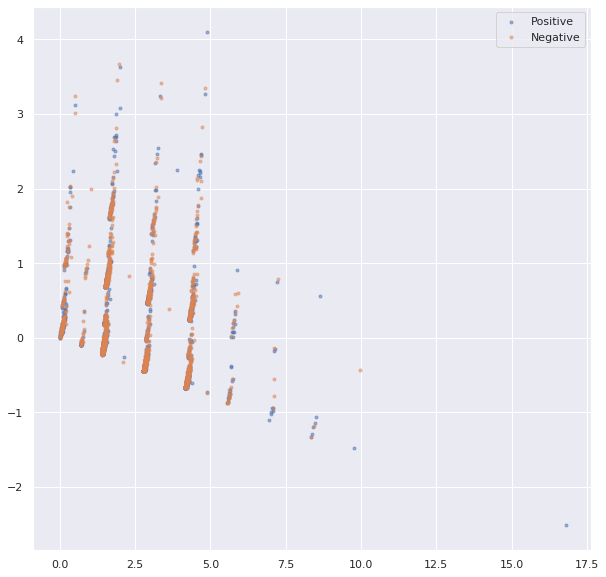

In [29]:
plot_embeddings(reduced_tfidf_train, y_train, 2000)    # bag of words

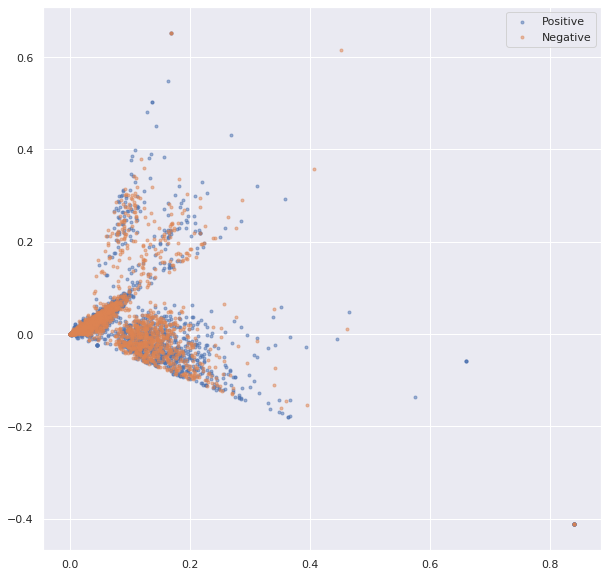

In [32]:
plot_embeddings(reduced_tfidf_train, y_train, 2000)    # tf-idf

In [0]:
p = train_vectors[y_train==1].sum(0) + 1
q = train_vectors[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=30, dual=True)
model.fit(train_vectors, y_train)
preds = model.predict(test_vectors)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.7802325581395348


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## FastText 80%

In [0]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2019-11-20 11:46:02--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/0.2.0 [following]
--2019-11-20 11:46:03--  https://codeload.github.com/facebookresearch/fastText/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [     <=>            ]   4.10M  2.78MB/s    in 1.5s    

2019-11-20 11:46:05 (2.78 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fastText-0.2.0

In [0]:
f = open('train.txt', 'w')
for i, tweet in enumerate(preprocessed_train):
    f.write('__label__' + str(training_y[i]) + " " + " ".join(tweet) + '\n')
f.close()

f = open('test.txt', 'w')
for i, tweet in enumerate(preprocessed_test):
    f.write(" ".join(tweet) + '\n')
f.close()

In [0]:
!./fasttext supervised -input train.txt -output model -dim 2

Read 0M words
Number of words:  13684
Number of labels: 2
Progress: 100.0% words/sec/thread:  661047 lr:  0.000000 loss:  0.454839 ETA:   0h 0m


In [0]:
!./fasttext predict model.bin test.txt > results.txt

In [0]:
predictions = []

with open('results.txt', 'r') as f:
    for line in f.readlines():
        predictions.append(int(line.replace('__label__', '')))

predictions[:10]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]

In [0]:
accuracy = accuracy_score(test_y, predictions, normalize=True, sample_weight=None)
print('Accuracy:', accuracy)

Accuracy: 0.8023255813953488


## Convolutional model

In [0]:
from keras.models import Model

In [75]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=vocab_size,
                          output_dim=embedding_size,
                          input_length=max_lenght,
                          weights=[w2v_weights],
                          # mask_zero=True, 
                          trainable=True)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(max_lenght,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

mc = ModelCheckpoint(PATH_TO_DIR + 'best_only_conv.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

history = model.fit(X_train, training_y,
          batch_size=128,
          epochs=200,
          callbacks=[mc],
          validation_data=(X_valid, validation_y))

Training model.
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 48)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 48, 100)           736400    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 44, 128)           64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4, 128)            82048     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)   

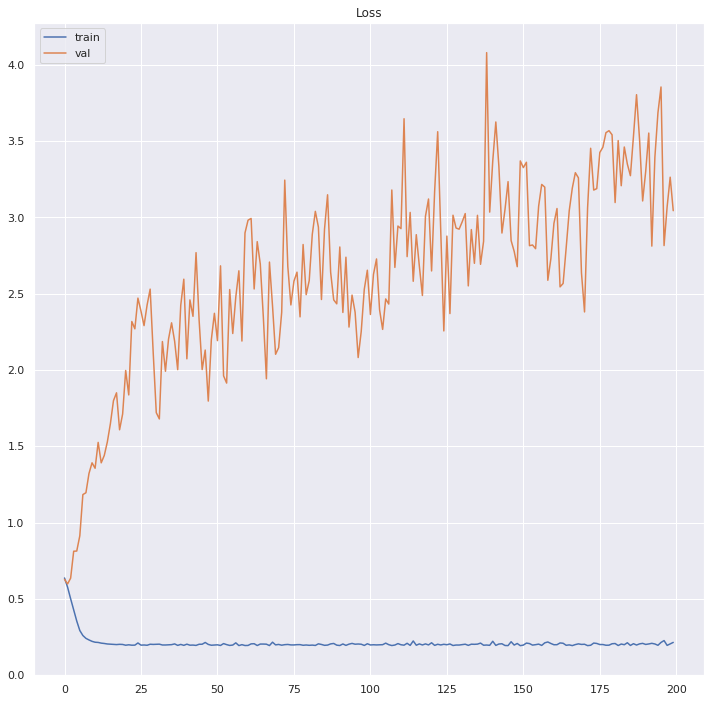

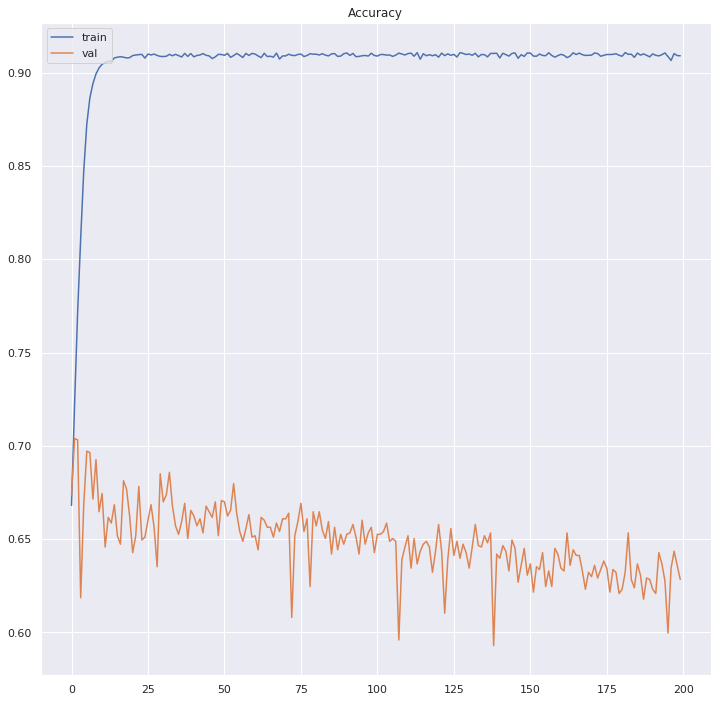

In [74]:
plot_history(history)

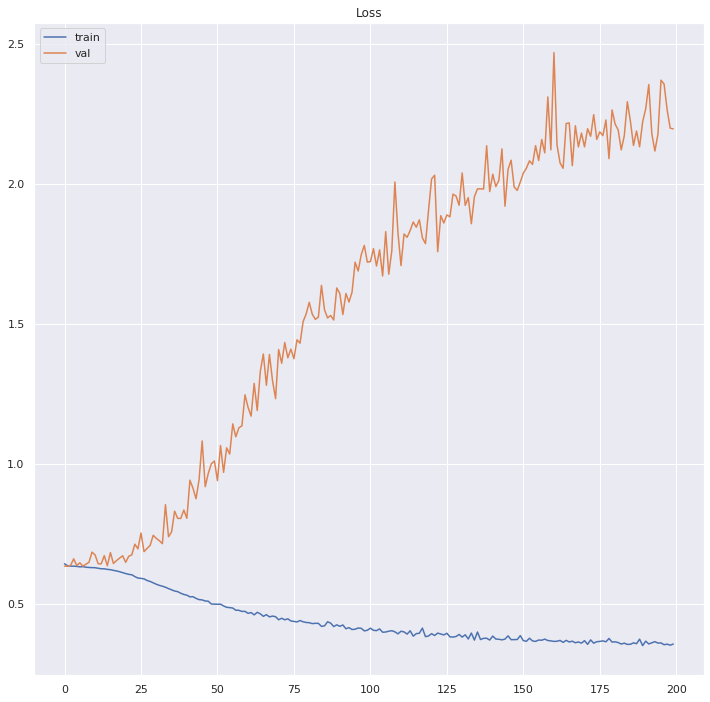

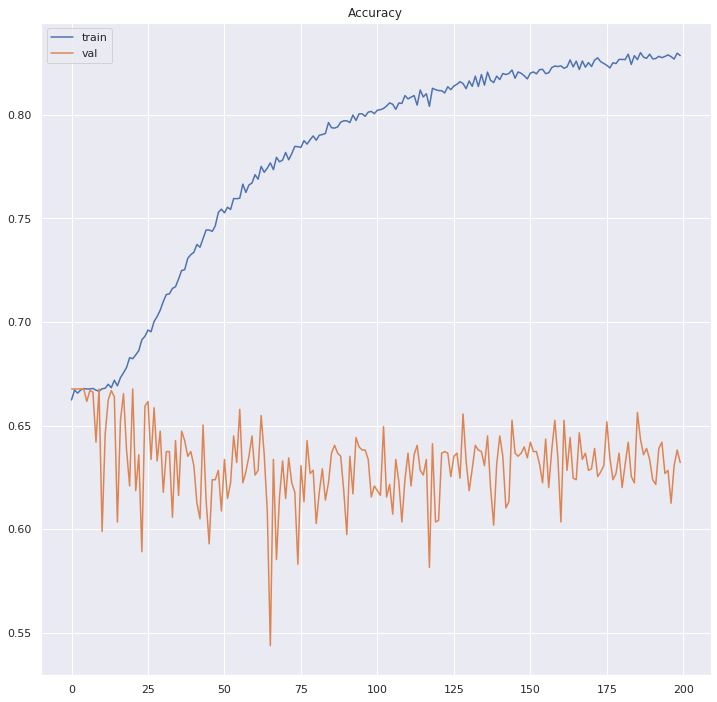

In [72]:
plot_history(history)

## Ensemble

In [69]:
preds_final = []
for i in range(len(preds_lstm)):
    prediction = (preds_lstm[i] + preds_svm[i]) / 2.0
    preds_final.append(prediction)

preds_final = np.asarray(preds_final)
preds_final.shape

(860,)

In [0]:
preds_final[preds_final > 0.5] = 1
preds_final[preds_final <= 0.5] = 0

In [73]:
accuracy = accuracy_score(test_y, preds_final, normalize=True)
print('Accuracy:', accuracy)

0.8209302325581396

## Notes

In [0]:
'''
Naïve Bayes: a family of probabilistic algorithms that uses Bayes’s Theorem to predict the category of a text.

Linear Regression: a very well-known algorithm in statistics used to predict some value (Y) given a set of features (X).

Support Vector Machines: a non-probabilistic model which uses a representation of text examples as points in a multidimensional space. 
These examples are mapped so that the examples of the different categories (sentiments) belong to distinct regions of that space.. 
Then, new texts are mapped onto that same space and predicted to belong to a category based on which region they fall into.

extremeText/fastText
tfidf+bow-NB

svc_tfidf           0.9656
svc                 0.9562
w2v_tfidf           0.9544
w2v                 0.9510
mult_nb             0.9467
glove_big           0.9274
glove_small         0.9262
glove_small_tfidf   0.9075
glove_big_tfidf     0.9038
mult_nb_tfidf       0.8615
bern_nb             0.7954
bern_nb_tfidf       0.7954

logistic regression -> https://itnext.io/machine-learning-sentiment-analysis-of-movie-reviews-using-logisticregression-62e9622b4532
'''